In [1]:
import os
import os.path
import time
import numpy as np
import tensorflow as tf
import cv2
import sys
import random
import functools
from tqdm import tqdm
from pathlib import Path
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt

import predrnn_pp
import dataset_utils
from nets import models_factory
from data_provider import datasets_factory
from utils import preprocess
from utils import metrics

In [20]:
sys.path.append('../../../')
from modis_utils.misc import cache_data, restore_data

In [3]:
data_dir = '../one_output/data_patch'

In [6]:
in_steps = 14
out_steps = 1
HEIGHT = 32
WIDTH = 32
DEPTH = 1

def parser(serialized_example):
    features = tf.parse_single_example(
        serialized_example,
        features={
            'inputs': tf.FixedLenFeature([in_steps * DEPTH * HEIGHT * WIDTH], tf.float32),
            'labels': tf.FixedLenFeature([out_steps * DEPTH * HEIGHT * WIDTH], tf.float32),
        })

    # Reshape from [in_steps * depth * height * width] to [in_steps, height, width, depth].
    inputs = tf.reshape(features['inputs'], [in_steps, HEIGHT, WIDTH, DEPTH])
    labels = tf.reshape(features['labels'], [out_steps, HEIGHT, WIDTH, DEPTH])

    return inputs, labels

In [12]:
dataset = tf.data.TFRecordDataset(os.path.join(data_dir, 'test.tfrecords'))
dataset = dataset.map(parser)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

In [13]:
inputs = []
labels = []

In [14]:
with tf.Session() as sess:
    try:
        while True:
            input_, label_ = sess.run(next_element)
            inputs.append(np.expand_dims(input_, axis=0))
            labels.append(label_)
    except:
        pass

In [15]:
inputs = np.vstack(inputs)
labels = np.vstack(labels)

In [16]:
inputs.shape, labels.shape

((2786, 14, 32, 32, 1), (2786, 32, 32, 1))

In [26]:
def get_inputs_labels_from_tfrecords(tfrecords_path):
    dataset = tf.data.TFRecordDataset(tfrecords_path)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    inputs = []
    labels = []
    with tf.Session() as sess:
        try:
            while True:
                input_, label_ = sess.run(next_element)
                inputs.append(np.expand_dims(input_, axis=0))
                labels.append(label_)
        except:
            pass
    inputs = np.vstack(inputs)
    labels = np.vstack(labels)
    return inputs, labels

In [27]:
if not os.path.exists('data'):
    os.makedirs('data')
for type_ in ('train', 'val', 'test'):
    inputs, labels = get_inputs_labels_from_tfrecords(
        os.path.join(data_dir, '{}.tfrecords'.format(type_)))
    cache_data((inputs, labels), os.path.join('data', '{}.dat'.format(type_)))

In [28]:
a = restore_data('data/train.dat')

In [29]:
a[0].shape, a[1].shape

((16096, 14, 32, 32, 1), (16096, 32, 32, 1))

In [30]:
inferences = restore_data('inferences/test.dat')

In [31]:
groundtruths = restore_data('data/test.dat')[1]

In [32]:
inferences.shape, groundtruths.shape

((2786, 32, 32, 1), (2786, 32, 32, 1))

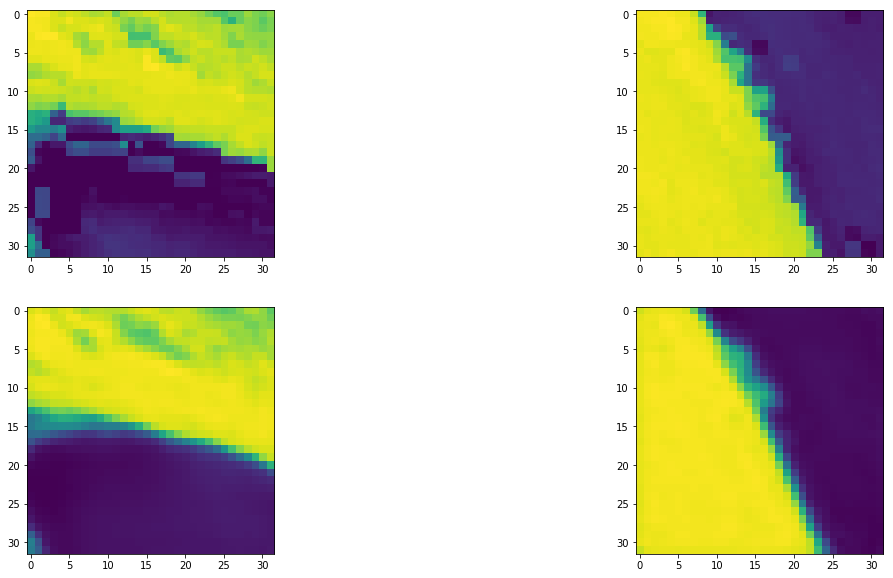

In [36]:
n_tests = 2
fig, axes = plt.subplots(2, n_tests, figsize=(20, 10))
for inference, groundtruth, ax_0, ax_1 in \
        zip(inferences[:n_tests], groundtruths[:n_tests], axes[0, :], axes[1, :]):
    ax_0.imshow(groundtruth.squeeze())
    ax_1.imshow(inference.squeeze())
plt.show()